In [64]:
import torch
import matplotlib.pyplot as plt
from torch import Tensor
import numpy as np
from torch.nn.modules import Conv2d, Module
from tqdm import tqdm

In [138]:
class LocalContextStandardization(Module):
    def __init__(
        self,
        in_channels: int = 3,
        kernel_size: int = 9,
        use_shift=True,
        dtype=torch.float32,
    ):
        super().__init__()

        self.use_shift = use_shift

        weights = torch.nn.Parameter(
            torch.zeros(
                in_channels, in_channels, kernel_size, kernel_size, dtype=dtype
            ),
            requires_grad=False,
        )
        for i in range(in_channels):
            weights[i, i] = (
                torch.ones(kernel_size, kernel_size, dtype=dtype) / kernel_size**2.0
            )

        self.conv = Conv2d(
            in_channels,
            in_channels,
            kernel_size=kernel_size,
            padding="same",
            padding_mode="replicate",
            bias=False,
        )
        self.conv.weight = weights

    def forward(self, x: Tensor) -> Tensor:
        if self.use_shift:
            x = x - x.mean(dim=(0, 2, 3), keepdims=True)
        mu = self.conv(x)
        squares = self.conv(x**2.0)
        variance = squares - mu**2.0
        return (x - mu) / (torch.sqrt(variance))

In [201]:
X = torch.randint(low=370, high=401, size=(1, 9, 5000, 5000), dtype=torch.float32)
div = (X.std(dim=(0, 2, 3)) ** 2.0) / X.mean(dim=(0, 2, 3))
div[0], (X.std(dim=(0, 2, 3)) ** 2.0)[0], X.mean(dim=(0, 2, 3))[0]

(tensor(0.2078), tensor(80.0061), tensor(384.9973))

In [174]:
low = 380
high = 400

xs = []
ys_float32 = []
for r in tqdm(range(1, 30)):
    mses = []
    for i in range(20):
        conv_size = 2 * r + 1
        X = torch.randint(
            low=low, high=high, size=(1, 9, conv_size, conv_size), dtype=torch.float32
        )
        model = LocalContextStandardization(
            9, kernel_size=conv_size, use_shift=True, dtype=torch.float32
        )
        X_std = model(X)

        computed = X_std[0, :, r, r]
        actual = (
            (X - X.mean(dim=(0, 2, 3), keepdims=True))
            / X.std(dim=(0, 2, 3), unbiased=False, keepdims=True)
        )[0, :, r, r]
        mse = torch.sqrt(torch.sum((computed - actual) ** 2.0))
        mses.append(mse.item())
    xs.append(r)
    ys_float32.append(np.mean(mses))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  9.09it/s]


In [175]:
ys_float64 = []
for r in tqdm(range(1, 30)):
    mses = []
    for i in range(20):
        conv_size = 2 * r + 1
        X = torch.randint(
            low=low, high=high, size=(1, 9, conv_size, conv_size), dtype=torch.float64
        )
        model = LocalContextStandardization(
            9, kernel_size=conv_size, use_shift=True, dtype=torch.float64
        )
        X_std = model(X)

        computed = X_std[0, :, r, r]
        actual = (
            (X - X.mean(dim=(0, 2, 3), keepdims=True))
            / X.std(dim=(0, 2, 3), unbiased=False, keepdims=True)
        )[0, :, r, r]
        mse = torch.sqrt(torch.sum((computed - actual) ** 2.0))
        mses.append(mse.item())
    ys_float64.append(np.mean(mses))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:26<00:00,  1.08it/s]


In [176]:
ys_float64_nomax = []
for r in tqdm(range(1, 30)):
    mses = []
    for i in range(20):
        conv_size = 2 * r + 1
        X = torch.randint(
            low=low, high=high, size=(1, 9, conv_size, conv_size), dtype=torch.float64
        )
        model = LocalContextStandardization(
            9, kernel_size=conv_size, use_shift=False, dtype=torch.float64
        )
        X_std = model(X)

        computed = X_std[0, :, r, r]
        actual = (
            (X - X.mean(dim=(0, 2, 3), keepdims=True))
            / X.std(dim=(0, 2, 3), unbiased=False, keepdims=True)
        )[0, :, r, r]
        mse = torch.sqrt(torch.sum((computed - actual) ** 2.0))
        mses.append(mse.item())
    ys_float64_nomax.append(np.mean(mses))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:26<00:00,  1.09it/s]


In [177]:
ys_float32_nomax = []
for r in tqdm(range(1, 30)):
    mses = []
    for i in range(20):
        conv_size = 2 * r + 1
        X = torch.randint(
            low=low, high=high, size=(1, 9, conv_size, conv_size), dtype=torch.float32
        )
        model = LocalContextStandardization(
            9, kernel_size=conv_size, use_shift=False, dtype=torch.float32
        )
        X_std = model(X)

        computed = X_std[0, :, r, r]
        actual = (
            (X - X.mean(dim=(0, 2, 3), keepdims=True))
            / X.std(dim=(0, 2, 3), unbiased=False, keepdims=True)
        )[0, :, r, r]
        mse = torch.sqrt(torch.sum((computed - actual) ** 2.0))
        mses.append(mse.item())
    ys_float32_nomax.append(np.mean(mses))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  8.75it/s]


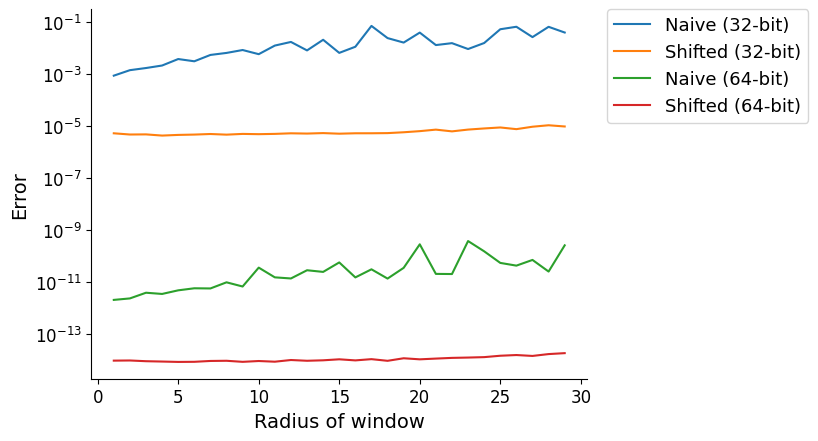

In [183]:
plt.figure()
ax = plt.gca()
plt.plot(xs, ys_float32_nomax, label="Naive (32-bit)")
plt.plot(xs, ys_float32, label="Shifted (32-bit)")
plt.plot(xs, ys_float64_nomax, label="Naive (64-bit)")
plt.plot(xs, ys_float64, label="Shifted (64-bit)")
# plt.legend()
l1 = plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=13)

plt.ylabel("Error", fontsize=14)
plt.xlabel("Radius of window", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale("log")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()
plt.close()

In [148]:
xs_new = []
ys_shift = []
ys_noshift = []
r = 15
for mean in tqdm(range(10, 20)):
    for stdev in np.arange(0.1, 3, 0.1):
        mses = []
        for i in range(20):
            conv_size = 2 * r + 1

            X = np.random.normal(
                loc=mean, scale=stdev, size=(1, 9, conv_size, conv_size)
            ).astype(np.float32)
            X = torch.from_numpy(X)
            model = LocalContextStandardization(
                9, kernel_size=conv_size, use_shift=False, dtype=torch.float32
            )
            X_std = model(X)

            computed = X_std[0, :, r, r]
            actual = (
                (X - X.mean(dim=(0, 2, 3), keepdims=True))
                / X.std(dim=(0, 2, 3), unbiased=False, keepdims=True)
            )[0, :, r, r]

            mse = torch.sqrt(torch.sum((computed - actual) ** 2.0))
            mses.append(mse.item())
        xs_new.append(stdev**2 / mean)
        ys_noshift.append(np.mean(mses))

for mean in tqdm(range(10, 20)):
    for stdev in np.arange(0.1, 3, 0.1):
        mses = []
        for i in range(20):
            conv_size = 2 * r + 1

            X = np.random.normal(
                loc=mean, scale=stdev, size=(1, 9, conv_size, conv_size)
            ).astype(np.float32)
            X = torch.from_numpy(X)
            model = LocalContextStandardization(
                9, kernel_size=conv_size, use_shift=True, dtype=torch.float32
            )
            X_std = model(X)

            computed = X_std[0, :, r, r]
            actual = (
                (X - X.mean(dim=(0, 2, 3), keepdims=True))
                / X.std(dim=(0, 2, 3), unbiased=False, keepdims=True)
            )[0, :, r, r]

            mse = torch.sqrt(torch.sum((computed - actual) ** 2.0))
            mses.append(mse.item())
        ys_shift.append(np.mean(mses))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.07s/it]


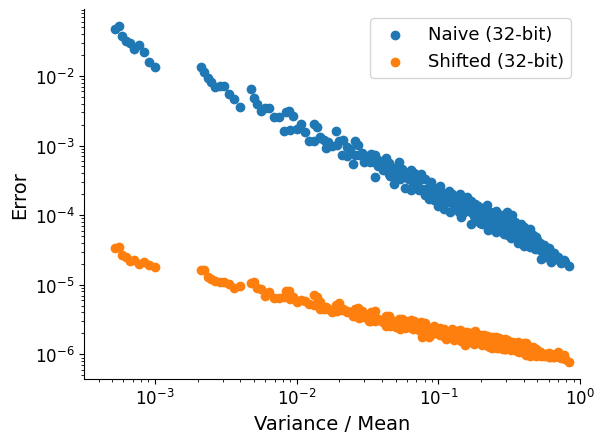

In [181]:
plt.figure()
ax = plt.gca()
plt.scatter(xs_new, ys_noshift, label="Naive (32-bit)")
plt.scatter(xs_new, ys_shift, label="Shifted (32-bit)")
plt.legend(fontsize=13)
plt.xlim([1 * 10**-3.5, 1])
plt.ylabel("Error", fontsize=14)
plt.xlabel("Variance / Mean", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale("log")
plt.xscale("log")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()
plt.close()